In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def calculate_std_and_share(data, task_column, share_column):
    temp_mean = np.average(data[task_column], weights=data[share_column])
    temp_sd = np.sqrt(np.average((data[task_column] - temp_mean)**2, weights=data[share_column]))
    std_column = (data[task_column] - temp_mean) / temp_sd
    return std_column

In [3]:
# Set the path to the parent directory of RR classes
os.chdir("C:\\Users\\lizan\\OneDrive\\Documents\\GitHub\\RRcourse2023\\6. Coding and documentation")

In [4]:
# Import data from the O*NET database, at ISCO-08 occupation level
task_data = pd.read_csv("Data\\onet_tasks.csv")

In [5]:
# Extract the first digit of the ISCO variable only
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

In [6]:
# Read employment data from Eurostat
isco_data = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name=None)

In [7]:
# Merge all these datasets and add the ISCO column
all_data = pd.concat(isco_data.values(), ignore_index=True)

In [8]:
# Extract the ISCO number from the column names
all_data["ISCO"] = all_data.columns.str.extract(r"ISCO(\d+)").fillna(-1).astype(int)

In [9]:
# Calculate total workers for each country
countries = ["Belgium", "Spain", "Poland"]
all_data["total_Belgium"] = all_data[countries].sum(axis=1)
all_data["total_Spain"] = all_data[countries].sum(axis=1)
all_data["total_Poland"] = all_data[countries].sum(axis=1)

In [10]:
# Calculate shares of each occupation among all workers in a period-country
for country in countries:
    all_data[f"share_{country}"] = all_data[country] / all_data[f"total_{country}"]

In [11]:
# Calculate mean task values at a 1-digit level
aggdata = task_data.groupby("isco08_1dig").mean().drop(columns=["isco08"])

In [23]:
# Combine the data
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')

In [24]:
# Calculate standard deviation for each task item in each country
for country in countries:
    for task_item in ["t_4A2a4", "t_4A2b2", "t_4A4a1"]:
        std_column = f"std_{country}_{task_item}"
        combined[std_column] = calculate_std_and_share(combined, task_item, f"share_{country}")

In [25]:
# Calculate non-routine cognitive analytical task content intensity
for country in countries:
    combined[f"{country}_NRCA"] = combined[[f"std_{country}_t_4A2a4", f"std_{country}_t_4A2b2", f"std_{country}_t_4A4a1"]].sum(axis=1)

In [26]:
# Calculate standard deviation for NRCA in each country
for country in countries:
    combined[f"std_{country}_NRCA"] = calculate_std_and_share(combined, f"{country}_NRCA", f"share_{country}")


In [27]:
# Calculate weighted mean for NRCA over time for each country
for country in countries:
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]

In [28]:
# Calculate aggregated data for plotting
agg_data = combined.groupby(["TIME"]).agg({f"multip_{country}_NRCA": "sum" for country in countries}).reset_index()

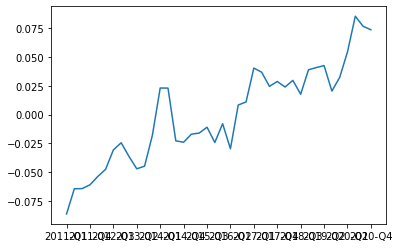

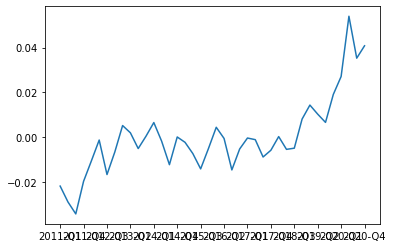

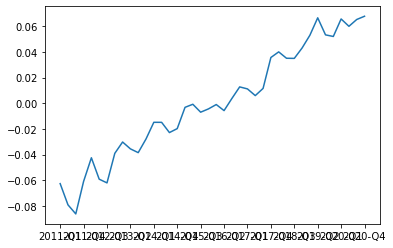

In [29]:
# Plot the data
for country in countries:
    plt.plot(agg_data["TIME"], agg_data[f"multip_{country}_NRCA"])
    plt.xticks(range(0, len(agg_data), 3), agg_data["TIME"][::3])
    plt.show()